In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import copy
from sklearn import linear_model

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('hyundi.csv', encoding = 'latin-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4860 non-null   object 
 1   year          4860 non-null   int64  
 2   price         4860 non-null   int64  
 3   transmission  4860 non-null   object 
 4   mileage       4860 non-null   int64  
 5   fuelType      4860 non-null   object 
 6   tax(Â£)       4860 non-null   int64  
 7   mpg           4860 non-null   float64
 8   engineSize    4860 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 341.8+ KB


In [4]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax(Â£)         0
mpg             0
engineSize      0
dtype: int64

In [5]:
# Rename 'tax' column for easier processing later on.
df = df.rename(columns={"tax(Â£)": "tax"})

In [6]:
# Create a new column 'age' (i.e., age of car) by subtracting 'year' column from current year.
# This creates a variable that not only seems more directly relevant, but also is of a data type (numeric) easier for linear regression.
df['age'] = 2021 - df['year']

In [7]:
df_1 = df[(df['fuelType']!='Other') & (df['transmission']!='Other')].copy()
df_1

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2,4
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0,5
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7,5
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0,5
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0,6
...,...,...,...,...,...,...,...,...,...,...
4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6,5
4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7,6
4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0,4
4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6,3


In [8]:
model1 = smf.ols('price ~ age + mileage + tax + mpg + engineSize + transmission + fuelType', data = df_1).fit()

In [9]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1658.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:32:52   Log-Likelihood:                -45726.
No. Observations:                4857   AIC:                         9.147e+04
Df Residuals:                    4847   BIC:                         9.154e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  2.341e+04    592.836     39.494      0.000    2.23e+04    2.46e+04
transmission[T.Manual]     -573.6976    163.877     -3.501      0.000    -894.971    -252.424
transmission[T.Semi-Auto]  2576.3300    186.505     13.814      0.000    2210.696    2941.964
fuelType[T.Hybrid]         4655.9358    235.439     19.776      0.000    4194.368    5117.503
fuelType[T.Petrol]        -3305.2921    157.309    -21.011      0.000   -3613.689   -2996.895
age                       -1062.6998     33.330    -31.884      0.000   -1128.042    -997.358
mileage                      -0.0748      0.004    -20.535      0.000      -0.082      -0.068
tax                          -5.3141      0.893     -5.953      0.000      -7.064      -3.564
mpg                        -154.2403      5.170    -29.833      0.000    -164.376    -144.105
engineSize                 3967.9351    184.904     21.459      0.000    3605.439    4330.431
==============================================================================
Omnibus:                     5771.906   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3320632.584
Skew:                           5.643   Prob(JB):                         0.00
Kurtosis:                     130.597   Cond. No.                     4.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

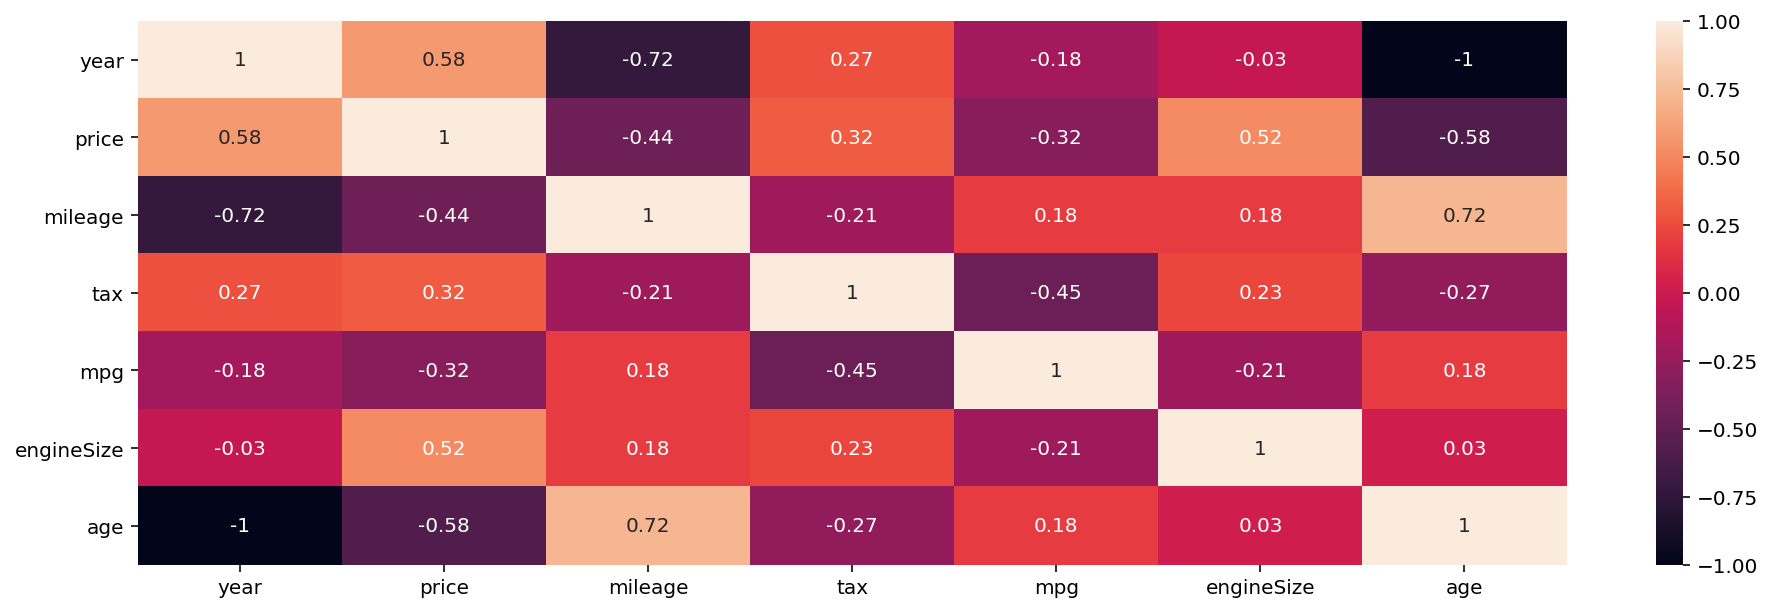

In [11]:
import seaborn as sns
correlation_matrix = df_1.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)


In [12]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('price ~ C(model) + age + mileage + tax + mpg + engineSize + C(transmission) + C(fuelType)', data=df_1, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

     VIF Factor                      features
0   5288.628465                     Intercept
1      2.008613            C(model)[T. Amica]
2      7.046780             C(model)[T. Getz]
3    881.168798              C(model)[T. I10]
4    463.797960              C(model)[T. I20]
5    497.321707              C(model)[T. I30]
6    129.963098              C(model)[T. I40]
7    121.572543             C(model)[T. I800]
8    203.266754             C(model)[T. IX20]
9    120.194619             C(model)[T. IX35]
10   282.843951            C(model)[T. Ioniq]
11   319.826842             C(model)[T. Kona]
12   244.489073         C(model)[T. Santa Fe]
13     3.071418         C(model)[T. Terracan]
14   993.599185           C(model)[T. Tucson]
15     4.085404         C(model)[T. Veloster]
16     3.254693     C(transmission)[T.Manual]
17     2.282523  C(transmission)[T.Semi-Auto]
18     5.365849         C(fuelType)[T.Hybrid]
19     5.519014         C(fuelType)[T.Petrol]
20     2.835291                   

In [13]:
infl = model1.get_influence()

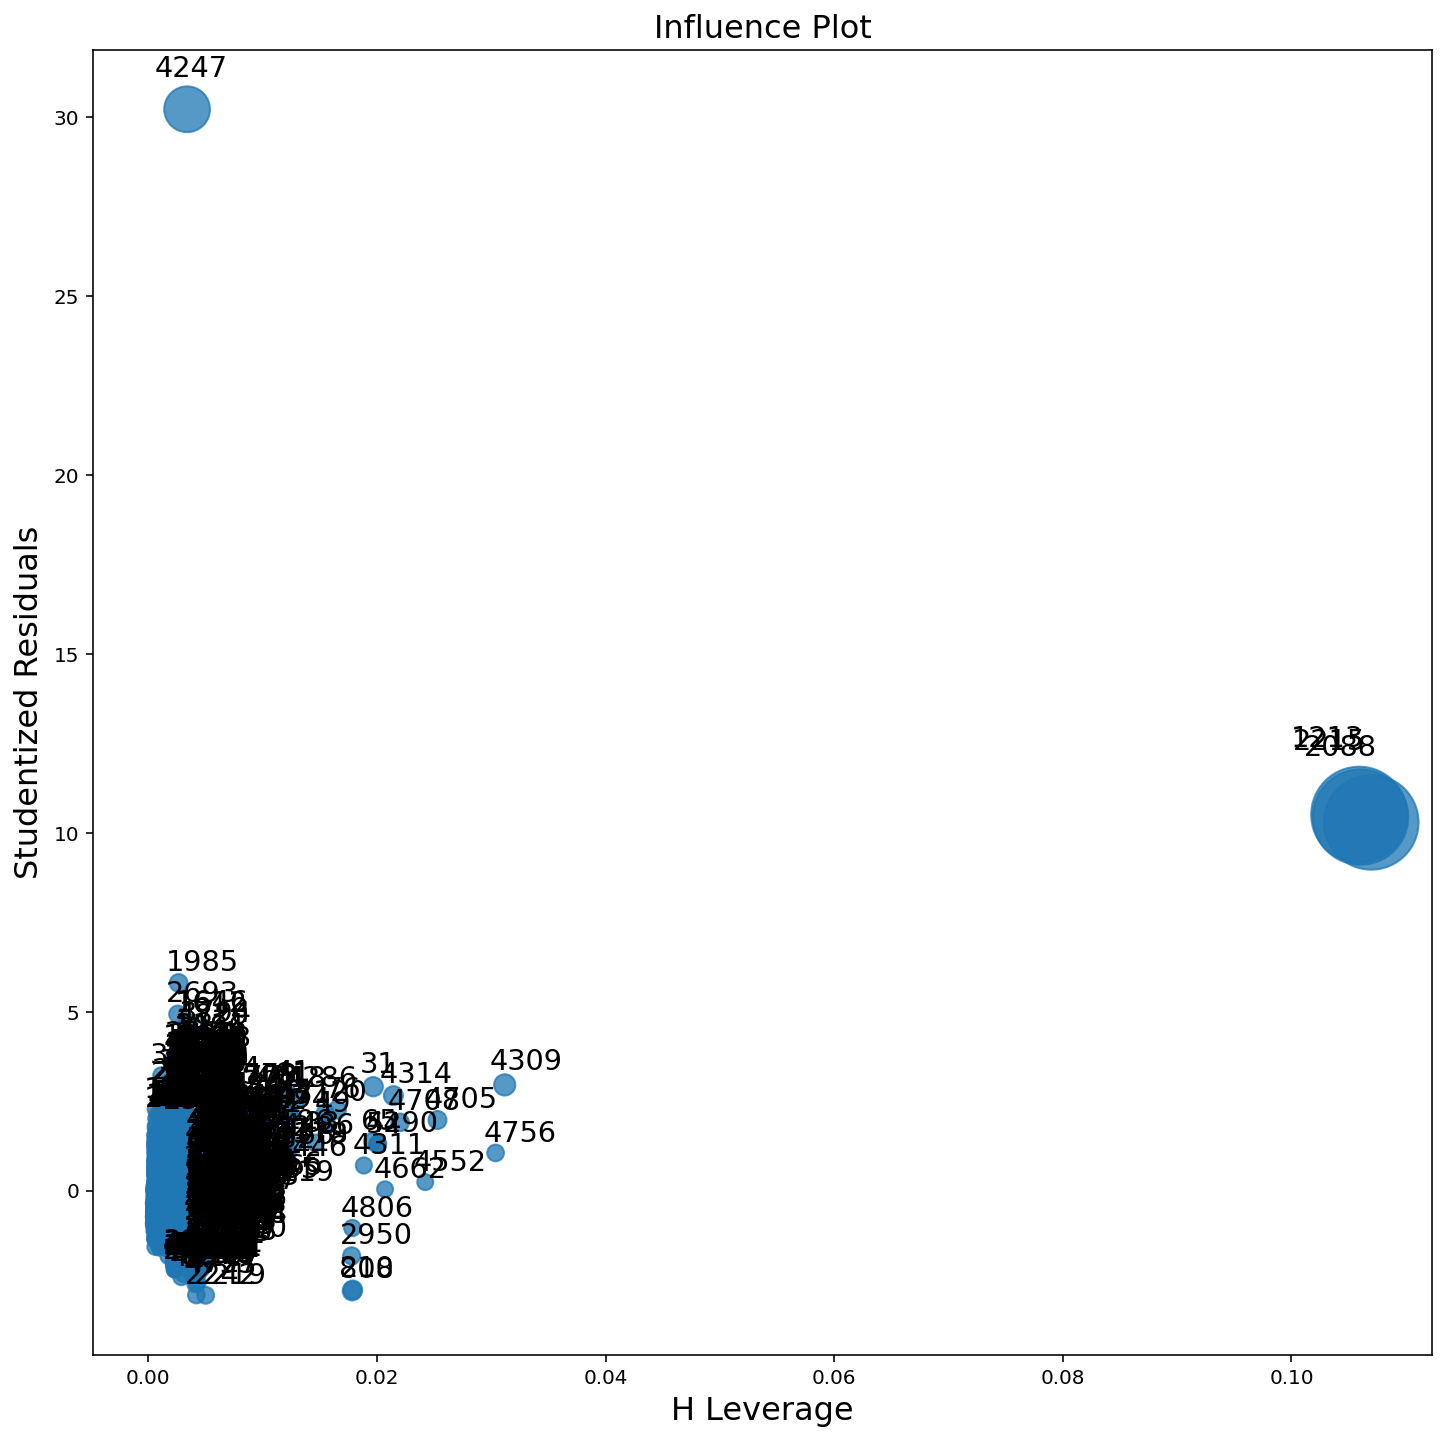

In [14]:
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model1,ax=ax, criterion="cooks")

Text(0.5, 1.0, 'Fitted Values vs. Residuals')

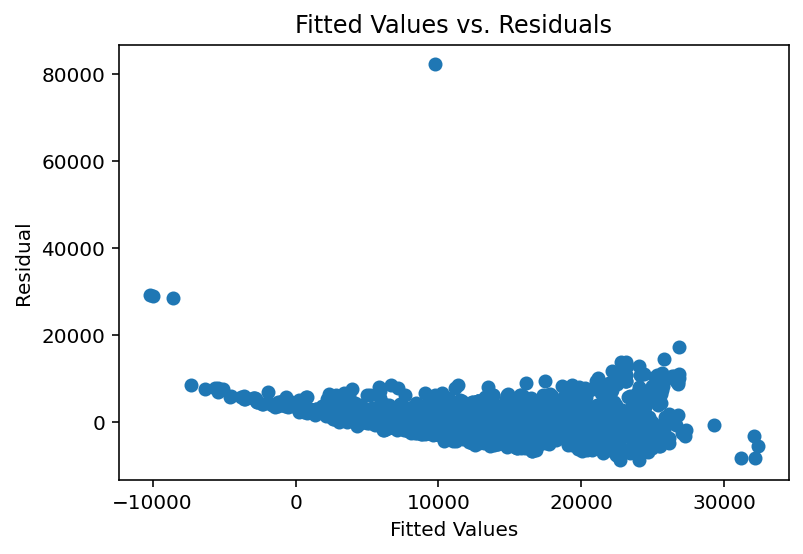

In [15]:
#Heteroscedasticity
#Fitted Values vs. Residuals Plot
p = model1.fittedvalues
res = model1.resid
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")


In [16]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model1.resid, model1.model.exog)
labels = ['LM Statistic', 'LM-Test p-value']
print(dict(zip(labels, bp_test)))

## Heteroskedasticity is present

{'LM Statistic': 76.61491057765437, 'LM-Test p-value': 7.578114939751345e-13}


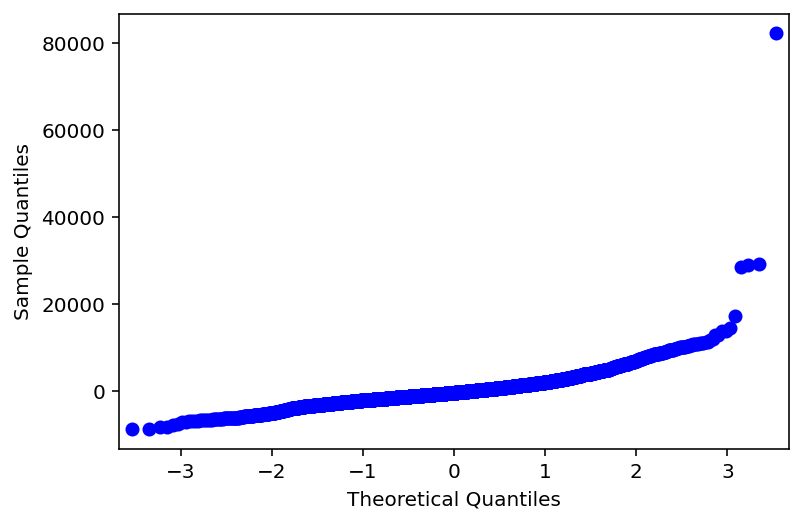

In [17]:
residual= model1.resid
a = sm.qqplot(residual)

In [18]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d
n = len(df_1)
atyp_cook = np.abs(reg_cook) >= 4/n
print(df_1.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([  31,   32,   33,   34,   40,   41,   42,   43,   45,   46,
            ...
            4768, 4770, 4772, 4781, 4798, 4805, 4806, 4808, 4818, 4820],
           dtype='int64', length=348) 31      0.016883
32      0.001778
33      0.002639
34      0.002017
40      0.001727
          ...   
4805    0.000835
4806    0.001994
4808    0.001227
4818    0.003129
4820    0.006644
Name: cooks_d, Length: 348, dtype: float64


In [19]:
#threshold externally studentized residuals
import scipy

p=10

seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#which ones?
print(df_1.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([  31,   41,   42,   43,   45,   47,   50,   53,   61,   63,
            ...
            4766, 4767, 4768, 4770, 4772, 4781, 4798, 4808, 4818, 4820],
           dtype='int64', length=222) [ 2.90178471  2.70866057  2.07860052  2.08547737  2.34020843  2.14206524
  2.22495409  2.13174428  2.65356454  1.96984417 -2.13974174  2.85436442
  2.25596684 -2.11988097  1.98394753  2.02715501  2.15590162  2.11156987
  3.21491331  3.2356894  -2.77622491 -2.34482411 -2.08438471 -2.09173438
 -2.11768214 -2.1026838   2.49148339  2.88270972 -2.04796881 -2.05467941
  3.24664123 -2.80828405  2.92301552  2.5155742   2.25129765  3.64196766
  3.99324601  2.08143473  3.31055544  2.54080376  2.68663888  2.07501396
 10.50397849 -2.35513346  2.95912545  2.1353582  -2.23042563 -2.32229626
 -2.21841069  2.76920029 -2.05733405 -2.02008055 -2.24012721  2.48095403
  2.35861454 -2.36569365  3.13893324  2.27457193  4.64965736  2.33786071
  2.08686457  4.69534173  2.24828807  2.03077292  3.45879954  2.1290807

In [20]:
infl_pts_final = set(df_1.index[atyp_cook]).intersection(set(df_1.index[atyp_stud]))

In [21]:
## Remove influential pts

df_no_infl = df_1.drop(infl_pts_final)

In [22]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4857 entries, 0 to 4859
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4857 non-null   object 
 1   year          4857 non-null   int64  
 2   price         4857 non-null   int64  
 3   transmission  4857 non-null   object 
 4   mileage       4857 non-null   int64  
 5   fuelType      4857 non-null   object 
 6   tax           4857 non-null   int64  
 7   mpg           4857 non-null   float64
 8   engineSize    4857 non-null   float64
 9   age           4857 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 546.4+ KB


In [23]:
df_no_infl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4648 entries, 0 to 4859
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4648 non-null   object 
 1   year          4648 non-null   int64  
 2   price         4648 non-null   int64  
 3   transmission  4648 non-null   object 
 4   mileage       4648 non-null   int64  
 5   fuelType      4648 non-null   object 
 6   tax           4648 non-null   int64  
 7   mpg           4648 non-null   float64
 8   engineSize    4648 non-null   float64
 9   age           4648 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 399.4+ KB


In [24]:
#log transform keeping influential points
df1_cp = df_1.copy()
df1_cp['log_price'] = np.log(df1_cp['price'])

In [25]:
model1a = smf.ols('log_price ~ age + mileage + tax + mpg + engineSize + transmission + fuelType', data = df1_cp).fit()
model1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     2994.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:33:08   Log-Likelihood:                 1427.6
No. Observations:                4857   AIC:                            -2835.
Df Residuals:                    4847   BIC:                            -2770.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.2240      0.036    283.798      0.000      10.153      10.295
transmission[T.Manual]       -0.0316      0.010     -3.169      0.002      -0.051      -0.012
transmission[T.Semi-Auto]     0.1179      0.011     10.405      0.000       0.096       0.140
fuelType[T.Hybrid]            0.2265      0.014     15.834      0.000       0.198       0.255
fuelType[T.Petrol]           -0.3226      0.010    -33.747      0.000      -0.341      -0.304
age                          -0.1158      0.002    -57.189      0.000      -0.120      -0.112
mileage                   -5.616e-06   2.21e-07    -25.374      0.000   -6.05e-06   -5.18e-06
tax                        5.016e-05   5.42e-05      0.925      0.355   -5.62e-05       0.000
mpg                          -0.0095      0.000    -30.211      0.000      -0.010      -0.009
engineSize                    0.2661      0.011     23.680      0.000       0.244       0.288
==============================================================================
Omnibus:                     1510.843   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26354.960
Skew:                           1.026   Prob(JB):                         0.00
Kurtosis:                      14.226   Cond. No.                     4.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
model1b = smf.ols('log_price ~ age + mileage + mpg + engineSize + transmission + fuelType', data = df1_cp).fit()
model1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     3369.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:33:08   Log-Likelihood:                 1427.1
No. Observations:                4857   AIC:                            -2836.
Df Residuals:                    4848   BIC:                            -2778.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.2355      0.034    302.737      0.000      10.169      10.302
transmission[T.Manual]       -0.0335      0.010     -3.440      0.001      -0.053      -0.014
transmission[T.Semi-Auto]     0.1170      0.011     10.364      0.000       0.095       0.139
fuelType[T.Hybrid]            0.2271      0.014     15.888      0.000       0.199       0.255
fuelType[T.Petrol]           -0.3219      0.010    -33.774      0.000      -0.341      -0.303
age                          -0.1161      0.002    -57.932      0.000      -0.120      -0.112
mileage                   -5.613e-06   2.21e-07    -25.362      0.000   -6.05e-06   -5.18e-06
mpg                          -0.0096      0.000    -31.998      0.000      -0.010      -0.009
engineSize                    0.2670      0.011     23.867      0.000       0.245       0.289
==============================================================================
Omnibus:                     1535.640   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27411.850
Skew:                           1.043   Prob(JB):                         0.00
Kurtosis:                      14.450   Cond. No.                     3.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
#log transform without influential points
df_no_infl['log_price'] = np.log(df_no_infl['price'])

In [28]:
model2 = smf.ols('log_price ~ age + mileage + tax + mpg + engineSize + transmission + fuelType', data = df_no_infl).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     3299.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:33:08   Log-Likelihood:                 1990.1
No. Observations:                4648   AIC:                            -3960.
Df Residuals:                    4638   BIC:                            -3896.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.5805      0.040    266.335      0.000      10.503      10.658
transmission[T.Manual]       -0.0094      0.009     -1.012      0.311      -0.028       0.009
transmission[T.Semi-Auto]     0.1126      0.011     10.534      0.000       0.092       0.134
fuelType[T.Hybrid]            0.3163      0.013     23.955      0.000       0.290       0.342
fuelType[T.Petrol]           -0.3730      0.010    -38.500      0.000      -0.392      -0.354
age                          -0.1139      0.002    -60.523      0.000      -0.118      -0.110
mileage                   -4.938e-06   1.99e-07    -24.822      0.000   -5.33e-06   -4.55e-06
tax                          -0.0002   4.98e-05     -4.621      0.000      -0.000      -0.000
mpg                          -0.0145      0.000    -40.357      0.000      -0.015      -0.014
engineSize                    0.2193      0.012     18.556      0.000       0.196       0.242
==============================================================================
Omnibus:                       44.297   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.878
Skew:                          -0.184   Prob(JB):                     8.95e-12
Kurtosis:                       3.358   Cond. No.                     5.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model Selection ###

In [143]:
finalmodel = 'age + mileage + mpg + engineSize + transmission + fuelType'
final_model_preds = finalmodel.split(' + ')

In [144]:
final_model_preds

['age', 'mileage', 'mpg', 'engineSize', 'transmission', 'fuelType']

In [145]:
predictors = list(final_model_preds)

In [146]:
predictors

['age', 'mileage', 'mpg', 'engineSize', 'transmission', 'fuelType']

#### All models

In [124]:
import itertools
all_models = []
for r in range(len(predictors) + 1):
    lst = list(itertools.combinations(predictors, r))
    all_models += lst

all_models = all_models[1:] 

all_model_eqns = []

for i in all_models:
    all_model_eqns.append(f'log_price~{"+".join(list(i))}')
    
len(all_model_eqns)

63

In [126]:
m_full =smf.ols(all_model_eqns[-1], df_no_infl).fit()
y_full = m_full.predict()
y = df_no_infl.log_price

In [130]:
m_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     3692.
Date:                Fri, 15 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:08:28   Log-Likelihood:                 1979.4
No. Observations:                4648   AIC:                            -3941.
Df Residuals:                    4639   BIC:                            -3883.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    10.4009      0.037    279.652      0.000      10.328      10.474
transmission[T.Manual]    -4.057e-05      0.009     -0.004      0.996      -0.018       0.018
transmission[T.Semi-Auto]     0.1181      0.011     11.095      0.000       0.097       0.139
fuelType[T.Hybrid]            0.3132      0.013     23.699      0.000       0.287       0.339
fuelType[T.Petrol]           -0.3722      0.010    -38.336      0.000      -0.391      -0.353
age                          -0.1125      0.002    -60.436      0.000      -0.116      -0.109
mileage                      -0.0868      0.003    -24.919      0.000      -0.094      -0.080
mpg                          -0.0139      0.000    -41.465      0.000      -0.015      -0.013
engineSize                    0.2179      0.012     18.405      0.000       0.195       0.241
==============================================================================
Omnibus:                       30.238   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.585
Skew:                          -0.174   Prob(JB):                     1.38e-07
Kurtosis:                       3.203   Cond. No.                         950.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [176]:
import RegscorePy
summary = []
for i, m in enumerate(all_model_eqns):
    print(i)
    model=smf.ols(m, df_no_infl).fit()
    y_sub = model.predict()
    mallow = RegscorePy.mallow.mallow(y = list(y), y_pred = list(y_full),
                                      y_sub = list(y_sub), 
                                      k = len(all_models[-1]) + 1, p = len(all_models[i]) + 1)
    summary.append([m, sum((y-y_sub)**2), len(all_models[i])+1, model.rsquared_adj, 
                    mallow ,model.aic, model.bic])
    


In [147]:
summary_df = pd.DataFrame(summary, columns=['Model', 'Sum_of_Sq', '# predictors', 
                                            'Adj. R sq.', 'Cp', 'aic', 'bic' ])

In [154]:
Final_Result = summary_df[['Model', 'Sum_of_Sq', '# predictors', 
                                            'Adj. R sq.', 'aic', 'bic' ]]

In [148]:
pd.set_option('display.max_rows', None)

In [169]:
summary_df

,Model,Sum_of_Sq,# predictors,Adj. R sq.,Cp,aic,bic
0,log_price~age,473.206589,2,0.446695,14269.210335,2575.351799,2588.240184
1,log_price~mileage,653.864846,2,0.235457,21489.793657,4078.369124,4091.257509
2,log_price~mpg,781.978246,2,0.085659,26610.254241,4910.018332,4922.906717
3,log_price~engineSize,660.477583,2,0.227725,21754.092792,4125.139679,4138.028064
4,log_price~transmission,705.631233,2,0.174751,23558.802417,4434.509989,4453.842566
5,log_price~fuelType,699.995263,2,0.181343,23333.542896,4397.236744,4416.569321
6,log_price~age+mileage,473.021996,3,0.446792,14263.832474,2575.538305,2594.870882
7,log_price~age+mpg,447.927787,3,0.476140,13260.862406,2322.176476,2341.509053
8,log_price~age+engineSize,207.898121,3,0.756859,3667.311388,-1245.553357,-1226.220780
9,log_price~age+transmission,370.645135,3,0.566430,10172.014787,1443.906011,1469.682780


In [177]:
summary_df[summary_df['Adj. R sq.'] > .8]

,Model,Sum_of_Sq,# predictors,Adj. R sq.,Cp,aic,bic
27,log_price~age+mpg+fuelType,145.103524,4,0.830226,1159.525049,-2912.977474,-2880.756513
43,log_price~age+mileage+mpg+fuelType,130.362780,5,0.847440,572.364219,-3408.900355,-3370.235201
44,log_price~age+mileage+engineSize+transmission,170.821877,5,0.800092,2189.441039,-2152.545129,-2113.879975
48,log_price~age+mpg+engineSize+fuelType,138.121809,5,0.838360,882.478558,-3140.177207,-3101.512053
49,log_price~age+mpg+transmission+fuelType,138.483317,5,0.837902,896.927373,-3126.027833,-3080.918487
56,log_price~age+mileage+mpg+engineSize+transmission,167.996243,6,0.803356,2078.505587,-2228.072558,-2182.963212
57,log_price~age+mileage+mpg+engineSize+fuelType,121.770023,6,0.857465,230.927292,-3723.833388,-3678.724042
58,log_price~age+mileage+mpg+transmission+fuelType,124.596399,6,0.854125,343.892396,-3615.182742,-3563.629203
59,log_price~age+mileage+engineSize+transmission+...,159.153983,6,0.813666,1725.096465,-2477.387299,-2425.833760
60,log_price~age+mpg+engineSize+transmission+fuel...,131.660215,6,0.845855,626.220355,-3358.869828,-3307.316290


In [ ]:
summary_df.to_csv('Summary_table.csv')
Final_Result.to_csv('Summary_table_final.csv')